Projet d'optimisation : effacement de consommation
=

**1. Étude du problème d'optimisation**

1. La facture s'écrit comme $\int_{t_0}^{t_f} c(t)P(t) \,dt = \sum_{i=0}^{N} \int_{t_i}^{t_i + \Delta t} c(t)P(t) \,dt$.\
Or, sur un intervalle $\Delta t$, le coût par unité de puissance et de temps est constant puisque la puissance ne varie pas.\
La facture s'écrit donc : $\sum_{i=0}^{N} c_iP_i\Delta t = \Delta t \sum_{i=0}^{N} c_iP_i$

2. L'équation (2) comprend les échanges thermiques avec l'extérieur- qui se font par convection- ainsi que la chaleur apportée par le chauffage de l'immeuble. Le premier terme permet en outre de prendre en compte l'inertie thermique du batiment. La température s'écrit donc comme la solution d'une équation différentielle dont la condition initiale est la température au début de l'intervalle considéré (à $t=t_i$).

Plus précisément, en notant $h$ le coeffcient de conducto-convection qui régit les échanges thermique entre une paroi et le milieu extérieur dans la loi de Newton, $k$ un coeffcient de même unité relatif à l'inertie du bâtiment, $T_e$ la température extérieure, et $P$ la puissance apportée par le chauffage, on considère l'équation différentielle, définie pour un temps $t>=t_0$:

$$(*)\hookrightarrow \frac{dT}{dt} + (k+h)T= bP + hT_e$$ 

La solution de cette équation du 1er ordre est: 
$$T= Ce^{-(k+h)t} + \frac {bP + hT_e}{k+h}$$ où C est une constante d'intégration à déterminer en utilisant la condition initiale: $T(t=t_0)=Ce^{-(k+h)t_0}+\frac{bP + hT_e}{k+h}=T_0 \Rightarrow C= (T_0 -\frac{bP + hT_e}{k+h})e^{(k+h)t_0}$.

D'où: $T(t)=(1- e^{-(k+h)(t-t_0)})\frac {bP + hT_e}{k+h} + T_0e^{-(k+h)(t-t_0)}$

Dans le modèle considéré, chaque température $T_{i+1}(t)$ sur l'intervalle $[t_i,t_{i+1}]$ est déterminée en fonction des données à l'instant précédent $t=t_i$, donc en fonction de $P=P(t_i)=P_i$, $T=T(t=t_i)=T_i$ et $T_e=T_e(t=t_i)=T_i^e$.

Ainsi, à tout temps, la température du bâtiment est solution de l'équation (*) avec pour condition initiale la température à l'instant précédent, ce qui s'écrit, $\forall i, 0 \leq i\leq N-1 $: $\forall t \in [t_i,t_{i+1}]$:

$$T(t)=(1- e^{-(k+h)(t-t_i)})\frac {bP_i + hT_i^e}{k+h} + T_i^e e^{-(k+h)(t-t_0)}$$

En particulier, à $t=t_{i+1}$, $t- t_i=t_{i+1}-t_i=\Delta t$, donc:

$$T_{i+1}=T(t_{i+1})=(1- e^{-(k+h)\Delta t})\frac {bP_i + hT_i^e}{k+h} + T_ie^{-(k+h)\Delta t}$$

3. Le problème d'optimisation, s'écrit, avec une fonction f à minimiser qui correspond au coût de la facture, à un facteur dt près qu'on omettra (le probleème de minimisation reste alors inchangé).
Ainsi, la variable d'action x sera le vecteur des puissances $P_0,P_1, \ldots, P_N$ et des températures $T_0,T_1, \ldots, T_N$ dans cet ordre: 
$$x= (P_0,P_1, \ldots, P_N,T_0,T_1, \ldots, T_N)^T$$
Et la fonction à minimiser:
$$f(x)=\sum_{i=0}^N c_iP_i=\sum_{i=0}^N c[i]*x[i]=\mathbf{c}^\intercal \mathbf{x}$$ 
Avec $c=(c_0,c_1, \ldots, c_N, 0,\ldots, 0)$, donc $c[i]=\left\{\begin{array}{rcl} c_i & \mbox{si} & 0 \leq i \leq N \\ 0 & \mbox{si} & N+1 \leq i \leq 2N+1 \end{array}\right.$

Les contraintes égalité et inégalité sont définies comme suit:
$$c_eq: x \in R^{2N+2} \mapsto c_eq(x)\in R^{2N+2}$$

$\forall x \in R^{2N+2}$, $c_{eq}(x)= \left\{\begin{array}{rcl} 0 & \mbox{si} & 0 \leq i \leq N-1 \\ x[N] & \mbox{si} & i=N \\x[N+1] - T_{in} & \mbox{si} & i=N+1\\ e^{-(k+h)dt} x[i-1] +\frac{1-e^{-(k+h)dt}}{k+h} (b*x[i-N-2]+hTe) \mbox{si} & N+2 \leq i \leq 2N+1 \end{array}\right.$

D'autre part: 
$$c_{in}(x)=(u,v) \in R^{2N+2}\times R^{2N+2}$$ 
Avec : 
$u= x - (P_M,\ldots, P_M,T_M,\ldots,T_M)^T = x - w^T $ et $ w=\begin{pmatrix} P_M  \\ \ldots\\ P_M \\T_M\\ \vdots\\T_M \end{pmatrix}=((P_M)_{0\leq i \leq N}, (T_M)_{N+1\leq i \leq 2N+1})$

et $v= z^T - x$ où $z=\begin{pmatrix} 0\\ \ldots\\0\\T_m\\ \vdots\\T_m \end{pmatrix}=((0)_{0\leq i \leq N}, (T_m)_{N+1\leq i \leq 2N+1})$


4. La fonction à minimiser est convexe (simple produit scalaire).\
Les contraintes égalité et inégalité sont également convexes car ce sont des fonction affines en x:
- les deux vecteurs du tableau renvoyé par c_in qui s'écrivent $u=x - w^T $ et $v= z^T - x$, où $w$ et $z$ sont constants, sont des transformations affines de x.
- le vecteurs renvoyé par c_in est, pour certains coefficient cin_k, une fonction affine de x_k, et pour d'autres, fait intervenir une exponentielle (certes convexe) mais qui,de toute manière, est constante car ne fait pas intervenir x mais seulement les constantes $k$,$h$ et $\Delta t$.

In [16]:
import numpy as np
from scipy import optimize
from casadi import *
import time
import autograd
import matplotlib.pyplot as plt

In [17]:
N=47 
dt=0.5
t0=23
k=0.01
h=0.05
b=1/500

In [18]:
Tm=18
T_in=Tm
TM=30
PM=5000
c_cr=1
c_pl=3/2

In [19]:
c=np.full(2*N+2, c_pl)

c[2:15]=c_cr
c[26:31]=c_cr
c[48:] = 0
print(c)

[1.5 1.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.  1.  1.  1.  1.  1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0. ]


In [20]:
"""def f(x):
    return np.dot(c,x)
    
def c_eq(x):
    c=np.zeros(2*N+2)
    c[N]=x[N]
    c[N+1]= x[N+1] - T_in
    t=t0
    
    for i in range(N+2,2*N+2):
        Te = 4+ 8*np.exp(-(t-12)**2/40)
        g = np.exp(-(k+h)*dt)*x[i-1] +(1-np.exp(-(k+h)*dt))*(b*x[i-1-(N+1)]+h*Te)/(k+h)
        c[i] = x[i]- g
        t += dt
    return c

def c_in(x):
    u=np.zeros(2*N+2)
    v=np.zeros(2*N+2)
    cin=np.zeros((2*N+2,2))
    for i in range(N+1, 2*N+2):
        if (16+N+1<=i and i<=20+N+1) or (38+N+1<=i and i<=47+N+1):
            v[i]=Tm - x[i]
            u[i]=x[i]- TM
    for i in range(0,N+1):
        u[i]=x[i]- PM
        v[i]= - x[i]
    cin[:,0]=u
    cin[:,1]=v
    return cin"""

'def f(x):\n    return np.dot(c,x)\n    \ndef c_eq(x):\n    c=np.zeros(2*N+2)\n    c[N]=x[N]\n    c[N+1]= x[N+1] - T_in\n    t=t0\n    \n    for i in range(N+2,2*N+2):\n        Te = 4+ 8*np.exp(-(t-12)**2/40)\n        g = np.exp(-(k+h)*dt)*x[i-1] +(1-np.exp(-(k+h)*dt))(b*x[i-1-(N+1)]+h*Te)/(k+h)\n        c[i] = x[i]- g\n        t += dt\n    return c\n\ndef c_in(x):\n    u=np.zeros(2*N+2)\n    v=np.zeros(2*N+2)\n    cin=np.zeros((2*N+2,2))\n    for i in range(N+1, 2*N+2):\n        if (16+N+1<=i and i<=20+N+1) or (38+N+1<=i and i<=47+N+1):\n            v[i]=Tm - x[i]\n            u[i]=x[i]- TM\n    for i in range(0,N+1):\n        u[i]=x[i]- PM\n        v[i]= - x[i]\n    cin[:,0]=u\n    cin[:,1]=v\n    return cin'

##### Avec Casadi

In [23]:
opti = casadi.Opti()
x = opti.variable(2*N+2)
f=0
for i in range(2*N+2):
    f+=x[i]*c[i]
    

opti.minimize(f)

#Contraintes inégalités
for i in range(0, 2*N+2):
    if (16+N+1 <= i and i <= 20+N+1) or (38+N+1 <= i and i <= 47+N+1):
        opti.subject_to(Tm - x[i] <= 0)
        opti.subject_to(x[i]- TM <= 0)
    elif i in range(0, N+1):
        opti.subject_to(- x[i] <= 0)
        opti.subject_to(x[i] - PM <=0)

t = t0

#Contraintes égalités
opti.subject_to(x[N] == 0)
opti.subject_to(x[N+1] - T_in == 0)

for i in range(N+2,2*N+2):
        Te = 4+ 8*np.exp(-(t-12)**2/40)
        g = np.exp(-(k+h)*dt)*x[i-1] +(b*x[i-1-(N+1)] + h*Te)*(1-np.exp(-(k+h)*dt))/(k+h)
        opti.subject_to(x[i] - g == 0)
        t += dt

#Définition du vecteur initial
x0 = np.zeros(2*N+2)

#Résolution et affichage des températures
opti.set_initial(x, x0)
opti.solver('ipopt')
sol = opti.solve()
print(sol.value(x[48:]))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      143
Number of nonzeros in inequality constraint Jacobian.:      126
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       96
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       49
Total number of inequality constraints...............:      126
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      126

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

**Affichage des résultats**

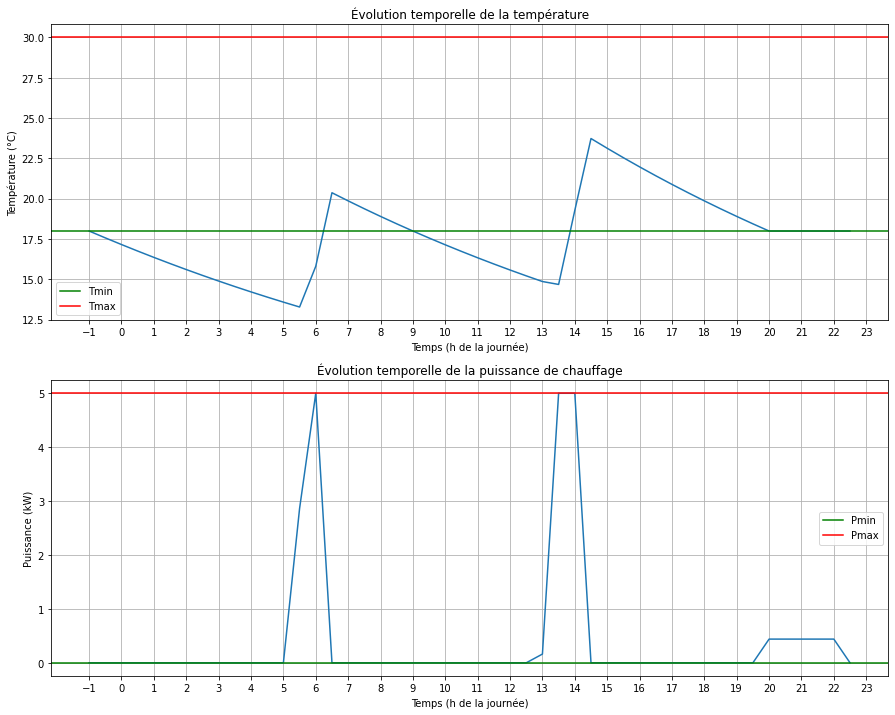

In [126]:
plt.figure(figsize = (15, 12))

plt.subplot(211)
plt.plot(np.linspace(-1, 22.5, 48), sol.value(x[48:]))
plt.title('Évolution temporelle de la température')
plt.ylabel('Température (°C)')
plt.xlabel('Temps (h de la journée)')
plt.axhline(Tm, color = 'g', label = 'Tmin')
plt.axhline(TM, color = 'r', label = 'Tmax')
plt.legend()
plt.xticks(np.linspace(-1, 23, 25))
plt.grid()

plt.subplot(212)
plt.plot(np.linspace(-1, 22.5, 48), sol.value(x[:48]*10**-3))
plt.title('Évolution temporelle de la puissance de chauffage')
plt.xlabel('Temps (h de la journée)')
plt.ylabel('Puissance (kW)')
plt.axhline(0, color = 'g', label = 'Pmin')
plt.axhline(PM*10**-3, color = 'r', label = 'Pmax')
plt.legend()
plt.grid()
plt.xticks(np.linspace(-1, 23, 25));

Il est à constaer une forte augmentation de la puissance de chauffage entre 5 et 6h d'une part, et 13 et 14h d'autre part, avec une légère hausse supplémentaire de 20 à 22h. Par ailleurs, les deux premiers intervalles pour lequels la puissance atteint le pic maximal autorise (PM= 5 kW), coincident avec les heures creuses du tarif, où le chauffage est le moins cher. Ainsi, on ne chauffe que lorsque le coût est le plus faible; en effet, le reste du temps, la courbe de puissance coindide avec la puissance minimale, qui est nulle, le chauffage est éteint en dehors de ces horaires. 


### Partie 3

Dans le cas de plusieurs logements au nombre de $n_l$, la variable x d'intérêt sera la concaténation des vecteurs $x_i$ associé à chacun des logements, où $x_i$ est similaire au cas de la partie 2 avec un seul logements: $x_j$ est le vecteur des puissances $P_{0j},P_{1j}, \ldots, P_{Nj}$ et des températures $T_{0j},T_{1j}, \ldots, T_{Nj}$ pour le logement j:

$$x_j=((P_{ij})_{0\leq i \leq N}, (T_{ij})_{N+1\leq i \leq 2N+1})$$ 
$$x=((P_{ij})_{0\leq i \leq N}, (T_{ij})_{N+1\leq i \leq 2N+1})_{1\leq j \leq n_l}$$

D'autre part, la fonction f à minimiser correspond au coût total des consommations électriques des $nl$ logements. Elle s'écrit donc (à un facteur $\delta t$ près):

$$f: x \in R^{(2N+2)n_l} \mapsto f(x)= \sum_{j=1}^{n_l} \sum_{i=0}^N c_{ij}P_{ij}=\sum_{j=1}^{n_l} \sum_{i=0}^N c[i+(2N+2)(j-1)]x[i +(2N+2)(j-1)]= \sum_{k=0}^{(2N+2)n_l -1} x[k]*c[k]= \mathbf{c}^\intercal \mathbf{x}$$
Ceci en notant le vecteur c des coûts comme la concaténation $n_l$ fois du vecteur c considéré dans la partie précédente à 1 logement. 

Les contraintes égalité et inégalité deviennent alors:

$c_{eq}: x \in R^{(2N+2)n_l} \mapsto (u_j)_{1 j \leq n_l} \in R^{(2N+2)n_l}$ et $\forall j,{1 \leq j \leq n_l}$ :
$u_j \in R^{(2N+2)}= \begin{pmatrix}  
0 \\ \vdots \\ 0 \\ x[N+(2N+2)*(j-1)] \\ x[N+1+(2N+2)*(j-1)] - T_{inj} \\ \vdots \\ x[i +(2N+2)(j-1)]- g_{ij}\end{pmatrix}$

avec $g_{ij}= e^{-(k+ h + \sum_{j \neq k} h_{jk})dt}x[i-1 +(2N+2)(j-1)] +\frac {1-e^{-(k+h+ \sum_{j \neq k} h_{jk})dt}}{k+h + \sum_{j \neq k}h_{jk}} (b*x[i-1-(N+1)+(2N+2)(j-1)]+h*T_{ie}+ \sum_{j \neq k} (h_{jk}x[i + (2N+2)(k-1)])) $

$c_eq(x)=\begin{pmatrix} 
0 & 0 & \ldots & 0 & \ldots & 0 \\  
\ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\
0 & 0 & \ldots & 0 & \ldots & 0 \\
x[N] & x[N + (2N+2)] & \ldots & x[N + (2N+2)(j-1)]  & \ldots & x[N + (2N+2)({n_l}-1)] \\
x[N+1]-T_{in1} & x[N+1+(2N+2)]-T_{in2} & \ldots & x[N+1+(2N+2)*(j-1)] - T_{inj} & \ldots & x[N+1+(2N+2)(n_l-1)] - T_{in} \\
\ldots & \ldots & \ldots & x[i +(2N+2)(j-1)]- e^{-(k+ h + \sum_{j \neq k} h_{jk})dt}x[i-1 +(2*N+2)(j-1)] +\frac {1-e^{-(k+h+ \sum_{j \neq k} h_{jk})dt}}{k+h + \sum_{j \neq k}h_{jk}} (bx[i-1-(N+1) +(2N+2)(j-1)]+hT_{ie}+ \sum_{j \neq k} h_{jk}x[i + (2N+2)(k-1)]) & \ldots & \ldots
\end{pmatrix}$

De même, on a : $c_{in}: x \in R^{(2N+2)n_l} \mapsto  (u_j, v_j)_{1 j \leq n_l} \in R^{(2N+2)\times 2n_l} $ avec $\forall j,{1 \leq j \leq n_l} $, c_in renvoie donc une matrice de taille (2N+2)*2n_l, les contraintes de chaque logement j étant représenté par deux colonnes successives de c_in.   

Avec $u_j=x - (P_{Mj},\ldots, P_{Mj},T_{Mj},\ldots,T_{Mj})^T = x - w_j^T $ et $ w_j=\begin{pmatrix} P_{Mj}  \\ \vdots\\ P_{Mj} \\T_{Mj}\\ \vdots\\T_{Mj} \end{pmatrix}=((P_{Mj})_{0\leq i \leq N}, (T_{Mj})_{N+1\leq i \leq 2N+1})$

et $v_j= z_j^T - x$ où $z_j=\begin{pmatrix} 0\\ \vdots\\0\\T_{mj}\\ \vdots\\T_{mj} \end{pmatrix}=((0)_{0\leq i \leq N}, (T_{mj})_{N+1\leq i \leq 2N+1})$

Donc, ici en désignant par j le numéro du logement et i le numéro de ligne dans la matrice:

$c_in(x)=\begin{pmatrix} 
x[0] - P_{M0} & 0 & \ldots & x[j-1] - P_{M_{j-1}} & 0 & \ldots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x[N] - P_{M0} & 0 & \ldots & x[N + (2N+2)(j-1)] - P_{M_{j-1}}  & 0 & \ldots \\
x[N+1] - T_{M0} & x[N+1] - T_{M0} & \ldots & x[N+1] - T_{M0} & x[N+1 + (2N+2)(j-1)] - T_{M_{j-1}} & \ldots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x[N+1] - T_{M0} & x[N+1] - T_{M0} & \ldots & x[N+1] - T_{M0} & x[N+1 + (2N+2)(j-1)] - T_{M_{j-1}} & \ldots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x[i +(2N+2)(j-1)] - T_{M0} & x[ i + (2N+2)(j-1)] - T_{M0} & \ldots & x[i+ (2N+2)(j-1)] - T_{M0} & x[i+ (2N+2)(j-1)] - T_{M_{j-1}} & \ldots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots
\end{pmatrix}$


In [63]:
#Si on veut minimiser le coût total des nl logements:
def f_bis(x):
    x_T=np.transpose(x)
    couts= np.matmul(x_T,c)
    return np.sum(couts)

In [64]:
Tm_1=18
Tm_2= 20
TM=30
PM=5000
c_cr=1
c_pl=3/2

In [75]:
a=np.full(2*N+2, c_pl)

a[2:15]=c_cr
a[26:31]=c_cr
a[48:] = 0
c=np.concatenate((a,a))


In [72]:
opti = casadi.Opti()
x = opti.variable(4*N+4)
f=0
for i in range(4*N+4):
    f+=x[i]*c[i]

opti.minimize(f)

#Contraintes inégalités
for i in range(0, 2*N+2):
    if (16+N+1 <= i and i <= 20+N+1) or (38+N+1 <= i and i <= 47+N+1):
        opti.subject_to(Tm_1 - x[i] <= 0)
        opti.subject_to(x[i]- TM <= 0)
        opti.subject_to(Tm_2 - x[i+(2*N+2)] <= 0)
    elif i in range(0, N+1):
        opti.subject_to(- x[i] <= 0)
        opti.subject_to(x[i] - PM <=0)
        opti.subject_to(x[i+(2*N+2)]- PM <= 0)
        opti.subject_to(- x[i+(2*N+2)] <= 0)

t = t0

#Contraintes égalités
for j in range(1,3):
    opti.subject_to(x[N + (2*N+2)*(j-1)]== 0)
    if j==1:
        opti.subject_to((x[N+1+(2*N+2)*(j-1)] - Tm_1) ==0)
    else:
        opti.subject_to((x[N+1+(2*N+2)*(j-1)] - Tm_2) ==0)

    for i in range(N+2,2*N+2):
        Te= 4+ 8*np.exp(-(t-12)**2/40)
        if j==1:
            g=np.exp(-(k+ 2*h)*dt)*x[i-1 +(2*N+2)*(j-1)] +(b*x[i-1-(N+1) +(2*N+2)*(j-1)]+h*Te+h*x[i + (2*N+2)])*(1-np.exp(-(k+2*h)*dt))/(k+2*h)
        else:
            g=np.exp(-(k+ 2*h)*dt)*x[i-1 +(2*N+2)*(j-1)] +(1-np.exp(-(k+2*h)*dt))*(b*x[i-1-(N+1) +(2*N+2)*(j-1)]+h*Te+h*x[i])/(k+2*h)
        opti.subject_to((x[i+(2*N+2)*(j-1)]- g) ==0)
        t+=dt
        
#Définition du vecteur initial
x0 = np.zeros(4*N+4)

#Résolution et affichage des températures
opti.set_initial(x, x0)
opti.solver('ipopt')
sol = opti.solve()
print(sol.value(x[48:]))
print(sol.value(x[144:]))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      380
Number of nonzeros in inequality constraint Jacobian.:      237
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      192
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       98
Total number of inequality constraints...............:      237
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      237

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

**Affichage des résultats**

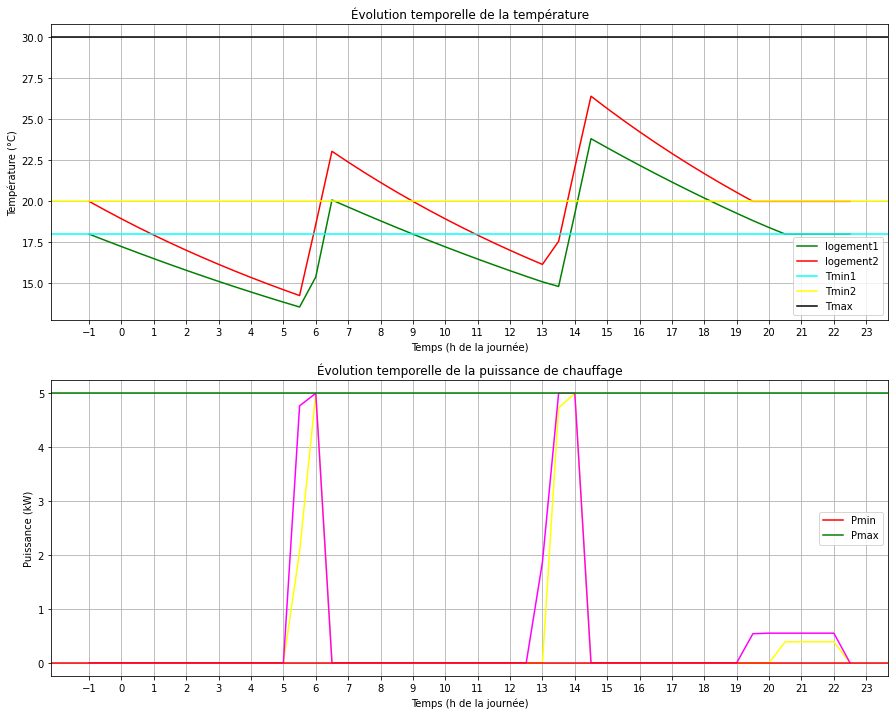

In [77]:
plt.figure(figsize = (15, 12))

plt.subplot(211)
plt.plot(np.linspace(-1, 22.5, 48), sol.value(x[48:96]),label='logement1', color='g')
plt.plot(np.linspace(-1, 22.5, 48), sol.value(x[144:]), label='logement2', color='r')
plt.title('Évolution temporelle de la température')
plt.ylabel('Température (°C)')
plt.xlabel('Temps (h de la journée)')
plt.axhline(Tm_1, color = 'cyan', label = 'Tmin1')
plt.axhline(Tm_2, color = 'yellow', label = 'Tmin2')
plt.axhline(TM, color = 'k', label = 'Tmax')
plt.legend()
plt.xticks(np.linspace(-1, 23, 25))
plt.grid()

plt.subplot(212)
plt.plot(np.linspace(-1, 22.5, 48), sol.value(x[:48]*10**-3), color='yellow')
plt.plot(np.linspace(-1, 22.5, 48), sol.value(x[96:144]*10**-3), color='magenta')
plt.title('Évolution temporelle de la puissance de chauffage')
plt.xlabel('Temps (h de la journée)')
plt.ylabel('Puissance (kW)')
plt.axhline(0, color = 'r', label = 'Pmin')
plt.axhline(PM*10**-3, color = 'g', label = 'Pmax')
plt.legend()
plt.grid()
plt.xticks(np.linspace(-1, 23, 25));

#### Question 9

On décompose le problème avec p variables de décision tel que $p = n_l$. On retrouve d'ailleurs le nom de méthode
décentralisée car chaque logement résout "son" problème de minimisation séparément. 
L'algorithme de décomposition-coordination s'écrit donc, pour la fonction f à minimiser: 

$ f(x) = f_1(x_1) + f_2(x_2) + \ldots f_p(x_p)$
Avec, $\forall j, 1\leq j \leq p=n_l$:

$$f_j(x_j)=\Delta t\sum_{i=0}^N c_{ij}P_{ij} +\varepsilon P_{ij}^2 =\Delta t\sum_{i=0}^N c[i+(2N+2)(j-1)]x[i +(2N+2)(j-1)]+\varepsilon.x[i +(N+1)*(j-1)]^2= \Delta t\sum_{k=0}^{(2N+2)n_l -1} x[k]*c[k] + \varepsilon\sum_{i=0}^N x[i +(N+1)*(j-1)]^2=\Delta t.\mathbf{c}^\intercal \mathbf{x} + \varepsilon\sum_{i=0}^N x[i +(N+1)*(j-1)]^2$$

Les contraintes égalité se décomposent comme suit:

$c_{eq}(x) = c_{{eq}_1}(x_1) + c_{{eq}_2}(x_2) + \ldots c_{{eq}_p}(x_p)$
Avec, $\forall j, 1\leq j \leq p=n_l$:

$$c_{{eq}_j}(x_j)=u_j \in R^{(2N+2)}= \begin{pmatrix}  
0 \\ \vdots \\ 0 \\ x[N+(2N+2)(j-1)] \\ x[N+1+(2N+2)(j-1)] - T_{inj} \\ \vdots \\ x[i +(2N+2)(j-1)]- g_{ij}\end{pmatrix}$$

avec $g_{ij}= e^{-(k+ h + \sum_{j \neq k} h_{jk})dt}x[i-1 +(2N+2)(j-1)] +\frac {1-e^{-(k+h+ \sum_{j \neq k} h_{jk})dt}}{k+h + \sum_{j \neq k}h_{jk}} (b*x[i-1-(N+1)+(2N+2)(j-1)]+h*T_{ie}+ \sum_{j \neq k} h_{jk}x[i + (2N+2)(k-1)])$

D'autre part, les contraintes inégalités se réécrivent: 
$c_{in}(x) = c_{{in}_1}(x_1) + c_{{in}_2}(x_2) + \ldots c_{{in}_p}(x_p)$
Avec, $\forall j, 1\leq j \leq p=n_l$:

$$c_{{in}_j}: x_j \in R^{(2N+2)n_l} \mapsto  (u_j, v_j) \in R^{2N+2}\times R^{2N+2}$$  

Avec $u_j=x - (P_{Mj},\ldots, P_{Mj},T_{Mj},\ldots,T_{Mj})^T = x - w_j^T $ et $ w_j=\begin{pmatrix} P_{Mj}  \\ \vdots\\ P_{Mj} \\T_{Mj}\\ \vdots\\T_{Mj} \end{pmatrix}=((P_{Mj})_{0\leq i \leq N}, (T_{Mj})_{N+1\leq i \leq 2N+1})$

et $v_j= z_j^T - x$ où $z_j=\begin{pmatrix} 0\\ \vdots\\0\\T_{mj}\\ \vdots\\T_{mj} \end{pmatrix}=((0)_{0\leq i \leq N}, (T_{mj})_{N+1\leq i \leq 2N+1})$


In [78]:
epsilon=0.01

In [79]:
def f_tres(x):
    x_T=np.transpose(x)
    cout= np.matmul(x_T,c)
    cout_final=dt*cout
    for j in range (1,3):
        for i in range (N+1):
            cout_final+=epsilon*(x[i +(N+1)*(j-1)]**2)
    return cout_final

In [80]:
#nl=2
def solveur (f,x0):
    n = 4*N+4
    opti = casadi.Opti()
    x = opti.variable(n)
    f=0
    for i in range(4*N+4):
        f+=dt*x[i]*c[i] 
    for j in range (1,3):
        for i in range (N+1):
            f+=epsilon*(x[i +(N+1)*(j-1)]**2)

    opti.minimize(f)

    #Contraintes inégalités
    for i in range(0, 2*N+2):
        if (16+N+1 <= i and i <= 20+N+1) or (38+N+1 <= i and i <= 47+N+1):
            opti.subject_to(Tm_1 - x[i] <= 0)
            opti.subject_to(x[i]- TM <= 0)
            opti.subject_to(Tm_2 - x[i+(2*N+2)] <= 0)
        elif i in range(0, N+1):
            opti.subject_to(- x[i] <= 0)
            opti.subject_to(x[i] - PM <=0)
            opti.subject_to(x[i+(2*N+2)]- PM <= 0)
            opti.subject_to(- x[i+(2*N+2)] <= 0)

    t = t0
    #Contraintes égalités
    for j in (1,3):
        if j==1:
            T_in=Tm_1
            indice_autre=2
        else:
            T_in=Tm_2
            indice_autre=1

        opti.subject_to(x[N + (2*N+2)*(j-1)]== 0)
        opti.subject_to((x[N+1+(2*N+2)*j] - T_in) ==0)

        for i in range(N+2,2*N+2):
            Te= 4+ 8*np.exp(-(t-12)**2/40)
            g=np.exp(-(k+ 2*h)*dt)*x[i-1 +(2*N+2)*(j-1)] +(1-np.exp(-(k+2*h)*dt))*(b*x[i-1-(N+1) +(2*N+2)*(j-1)]+h*Te+h*x[i + (2*N+2)*(indice_autre -1)])/(k+2*h)
            opti.subject_to(x[i+(2*N+2)*(j-1)]- g ==0)
            t+=dt
    #Définition du vecteur initial
    x0 = np.zeros(4*N+4)

    #Résolution et affichage des températures
    opti.set_initial(x, x0)
    opti.solver('ipopt')
    sol = opti.solve()
    return sol.value(x[48:96]), sol.value(x[144:])

    
    #c1=c_in_bis(x)
    #opti.minimize(f)
    #opti.subject_to(c1[:,0]<=0)
    #opti.subject_to(c1[:,1]<=0)
    #opti.subject_to(c1[:,2]<=0)
    #opti.subject_to(c1[:,3]<=0)
    
    #c2=c_eq_bis(x)
    #opti.subject_to(c2[:,0]==0)
    #opti.subject_to(c2[:,1]==0)

    #opti.set_initial(x,x0)
    #opti.solver('ipopt')
    #sol = opti.solve()
    #return sol.value(x)

In [82]:
p=2 
n=4*N+4 #taille de x
def fj(x,j): #j=1 ou 2
    xj=x[2*(N+1)*(j-1): 2*(N+1) + 2*(N+1)*(j-1)]
    cj=c[2*(N+1)*(j-1): 2*(N+1) + 2*(N+1)*(j-1)]
    xj_T=np.transpose(xj)
    cout= np.matmul(xj_T,cj)
    cout_final_j=cout
    for i in range (N+1):
        cout_final_j+=epsilon*(x[i +(N+1)*(j-1)]**2) 
    return cout_final_j

def cj(x,j):
    c1=c_eq_bis(x)
    c2=c_in_bis(x)
    if j==1:
        cj=np.concatenate(c1[:,0], c2[:,0],c2[:,1])
    else:
        cj=np.concatenate(c1[:,1],c2[:,2], c2[:,3])
    return cj

In [87]:
#lambda est de taille 3*(2N+2)

def decomposition_coordination(fun, x0, lambda_0, rho=0.1,N_iter=40,epsilon=0.01): 
    m=len(lambda_0)
    k=0
    xk=x0
    lambda_ki=lambda_0
    lambda_kf=np.maximum(np.zeros(m), lambda_ki + rho*(cj(xk,1)+ cj(xk,2)))
    while np.absolute(lambda_kf-lambda_ki) >=epsilon and (k+1) <N_iter:
        k+=1
        lambda_ki=lambda_kf
        a=xk
        for j in range (1,3):
            xj=xk[2*(N+1)*(j-1): 2*(N+1) + 2*(N+1)*(j-1)]
            f=fj(xj)+np.matmul(np.transpose(lambda_ki),cj(a,j))
            xk[j-1]=solveur(f,a)
        lambda_kf=np.maximum(np.zeros(m), lambda_ki + rho*(cj(xk,1)+ cj(xk,2)))
    return k, xk

In [88]:
x0=np.zeros(4*N+4)
lambda_0=np.zeros(3*(2*N+2))
x,k=decomposition_coordination(f_tres, x0, lambda_0, rho=0.1,N_iter=40,epsilon=0.01)

IndexError: index 239 is out of bounds for axis 0 with size 192